In [9]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import ks_2samp
from scipy.optimize import minimize

import george
from george import kernels

In [2]:
data = np.random.randn(1000)
# x0 = np.random.randn(len(data))

def get_stats(x):
    return np.array((np.mean(x), np.log(np.var(x))))

data_stats = get_stats(data)

def get_theta_stats(theta):
    mu, ln_sig = theta
    x = mu + np.exp(ln_sig) * np.random.randn(len(data))
    return get_stats(x)

def get_distance(params):
    mu, ln_sig = params
    x = mu + np.exp(ln_sig) * np.random.randn(len(data))
    stats = get_stats(x)
    return np.sum((stats - data_stats) ** 2)

# def resample():
#     global x0
#     x0 = np.random.randn(len(data))
    
prior_mean = np.array([0.0, 0.0])
prior_std = np.array([1.0, 1.0])

def lnprior(theta):
    return -0.5 * np.sum(((theta - prior_mean) / prior_std)**2, axis=-1)

def from_prior(size=1):
    return prior_mean[None] + prior_std[None] * np.random.randn(size, len(prior_mean))

In [3]:
def lnlike(theta):
    mu, ln_sig = theta
    return -0.5 * np.sum((data - mu)**2)*np.exp(-2.*ln_sig) - len(data) * ln_sig

def lnprob(theta):
    return lnlike(theta) + lnprior(theta)

In [4]:
training_theta = from_prior(1000)
training_stats = np.array(list(map(get_theta_stats, training_theta)))
training_lnlike = -0.5*np.sum((training_stats - data_stats) ** 2, axis=1)

mask = training_lnlike > training_lnlike.max() - 10

training_theta = training_theta[mask]
training_stats = training_stats[mask]
training_lnlike = training_lnlike[mask]

In [5]:
gps = [None for _ in range(training_stats.shape[1])]

def get_gps(thetas, stats, verbose=False, optimize=True):
    # metric = np.cov(thetas, rowvar=0)
    metric = np.var(thetas, axis=0)
    
    new = len(gps) > 0

    for i in range(stats.shape[1]):
        y = stats[:, i]
        
        gp = gps[i]
        if gp is None:
            amp = np.var(y)
            sigma2 = 1e-8 * np.sqrt(np.median((y - np.median(y))**2))
            kernel = amp * kernels.Matern32Kernel(np.array(metric), ndim=thetas.shape[1])
            gp = george.GP(kernel,
                           white_noise=sigma2, fit_white_noise=True,
                           mean=np.mean(y), fit_mean=True)
        else:
            gp = gp[0]
        gp.compute(thetas)
        
        if optimize:
            bounds = gp.get_bounds()
            bounds[1] = (-8, None)
            result = minimize(gp.nll, gp.get_vector(), jac=gp.grad_nll, args=(y, ),
                              method="L-BFGS-B", bounds=bounds)
            gp.set_vector(result.x)
            if verbose:
                print(result)

        gps[i] = (gp, y, float(np.exp(gp.white_noise.get_vector())))
    
    return gps

In [6]:
gps = get_gps(training_theta, training_stats, verbose=True)

  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
     nfev: 92
      nit: 26
      jac: array([  2.74342974e-06,  -4.56633768e-03,  -2.94791535e-04,
         5.62795619e-04,   3.10156528e-05])
  success: False
   status: 2
        x: array([  1.18143569,  -5.30079499,  14.07785931,  17.25247858,  38.70223789])
      fun: -1173.6825216848438
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
     nfev: 54
      nit: 24
      jac: array([ -1.16125238e-06,  -1.11117414e-01,  -6.18014336e-02,
        -3.07003567e-05,   7.21587157e-02])
  success: True
   status: 0
        x: array([ -0.04020563,  -6.24672722,  15.71122709,  39.15419295,  17.5222904 ])
      fun: -1627.5854440127932


In [7]:
mus = [gp.sample_conditional(y, training_theta) for gp, y, _ in gps]

/Users/dfm/anaconda/lib/python3.4/site-packages/george-1.0.0.dev0-py3.4-macosx-10.5-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


/Users/dfm/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/dfm/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


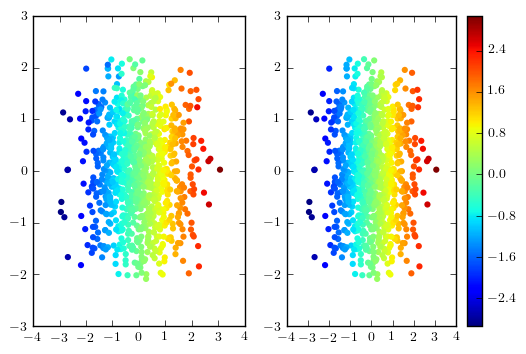

In [11]:
i = 0
y = training_stats[:, i]
vmin = y.min()
vmax = y.max()

fig, axes = pl.subplots(1, 2)
cf = axes[0].scatter(training_theta[:, 0], training_theta[:, 1], c=y, edgecolor="none", vmin=vmin, vmax=vmax)
axes[1].scatter(training_theta[:, 0], training_theta[:, 1], c=mus[i], edgecolor="none", vmin=vmin, vmax=vmax)
pl.colorbar(cf)

In [12]:
def gpsabc_mh_step(theta, error_tol, M=100, stepsize=0.1):
    global gps, training_theta, training_stats
    while True:
        theta_prime = theta + stepsize*np.random.randn(len(theta))
        alpha = lnprior(theta_prime) - lnprior(theta) + np.zeros(M)
        X = np.vstack((theta, theta_prime))
        for i, (gp, y, sigma2) in enumerate(gps):
            mu = gp.sample_conditional(y, X, size=M)
            norm = -0.5 * (mu - data_stats[i])**2 / sigma2
            alpha += np.diff(norm, axis=1)[:, 0]

        tau = np.median(alpha)

        u = np.log(np.random.rand(1000))
        p_minus = np.mean(alpha[None, :] <= u[:, None], axis=1)
        p_plus = 1.0 - p_minus
        error = np.mean((u <= tau) * p_minus + (u > tau) * p_plus)
        print(error)
        if error > error_tol:
            training_theta = np.concatenate((training_theta, theta_prime[None, :]), axis=0)
            training_stats = np.concatenate((training_stats, (get_theta_stats(theta_prime))[None, :]), axis=0)
            gps = get_gps(training_theta, training_stats, optimize=False)
        else:
            if np.log(np.random.rand()) < tau:
                return theta_prime
            return theta

In [65]:
chain = np.empty((1000, training_theta.shape[1]))
chain[0] = training_theta[np.argmax(training_lnlike)]
for i in range(1, len(chain)):
    chain[i] = gpsabc_mh_step(chain[i-1], 0.1, M=5000, stepsize=np.array([0.05, 0.05]))

0.0003762
0.0001322
0.0
0.0369912
0.0080132
0.0172236
0.0019474
0.000995
0.0057958
0.0003842
0.0
0.0278644
0.0009024
0.0011274
0.0
4e-06
0.0
0.0003074
0.0163602
0.0
0.0009816
0.0
0.010046
0.0101948
0.0115302
0.0298406
0.0008644
0.0070334
4.42e-05
0.0030422
0.007675
0.017325
0.0021888
0.0
0.0
0.0085698
0.0
0.0
0.0
0.0035344
0.0170696
0.0
0.0
0.0009268
0.0
0.0004502
0.024292
0.0004976
0.0
0.0096188
0.0374286
0.0014432
0.020337
0.0
0.0120536
0.0006844
0.0
0.0251354
2.2e-06
0.0138826
0.0
0.001387
0.0004116
0.0
0.0024126
0.0
0.0071428
0.003815
0.0
0.0006782
0.0
0.001497
0.0052976
0.0032246
0.0014334
0.0026018
0.0061382
0.0
0.0131964
0.0258254
4.8e-06
0.000768
0.0019304
0.0
0.0083578
0.0088782
2e-07
0.0130826
0.0
0.03256
0.0019238
0.0008718
0.0060528
0.0014102
0.0039438
0.0108542
0.0
0.0058678
0.0008574
0.0186304
0.0
6e-07
0.012972
0.0149592
0.0023918
0.0
0.020805
0.0391566
0.0180426
0.0006122
0.0227588
0.0062264
0.0
0.0003502
0.0278402
0.005622
0.0
0.004766
0.0272372
0.00298
0.0452058
0.000

/Users/dfm/anaconda/lib/python3.4/site-packages/george-1.0.0.dev0-py3.4-macosx-10.5-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


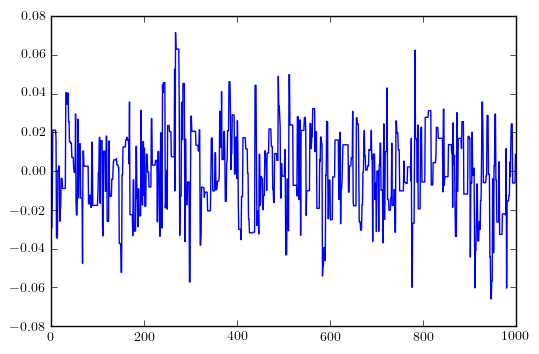

In [77]:
pl.plot(chain[:, 1])

In [67]:
gps = get_gps(training_theta, training_stats, verbose=True)

  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
     nfev: 21
      nit: 0
      jac: array([  2.74936690e-06,  -7.05461711e-02,   2.11643577e-02,
        -3.02718907e-02,   7.43488150e-05])
  success: False
   status: 2
        x: array([  1.18143522,  -5.6877685 ,  14.07754969,  17.25314666,  38.70223003])
      fun: -2271.9744412445416
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
     nfev: 21
      nit: 0
      jac: array([ -1.14127277e-06,   2.26654911e-02,  -5.37195206e-02,
        -3.83255429e-05,   6.81322803e-02])
  success: False
   status: 2
        x: array([ -0.04020551,  -6.26100152,  15.71562948,  39.15419678,  17.51538784])
      fun: -2729.3722654358071


In [68]:
mus = [gp.sample_conditional(y, training_theta) for gp, y, _ in gps]

/Users/dfm/anaconda/lib/python3.4/site-packages/george-1.0.0.dev0-py3.4-macosx-10.5-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


In [69]:
len(training_theta)

1610

/Users/dfm/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


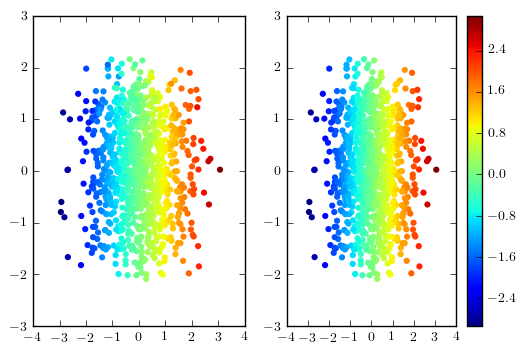

In [71]:
i = 0
y = training_stats[:, i]
vmin = y.min()
vmax = y.max()

fig, axes = pl.subplots(1, 2)
cf = axes[0].scatter(training_theta[:, 0], training_theta[:, 1], c=y, edgecolor="none", vmin=vmin, vmax=vmax)
axes[1].scatter(training_theta[:, 0], training_theta[:, 1], c=mus[i], edgecolor="none", vmin=vmin, vmax=vmax)
pl.colorbar(cf)

In [72]:
ndim, nwalkers = 2, 36
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

p0 = from_prior(nwalkers)
pos, _, _ = sampler.run_mcmc(p0, 300);
sampler.reset()
pos, _, _ = sampler.run_mcmc(pos, 1000);

0.0201042346336 0.0145719608143
0.0558286034134 0.0320586104007


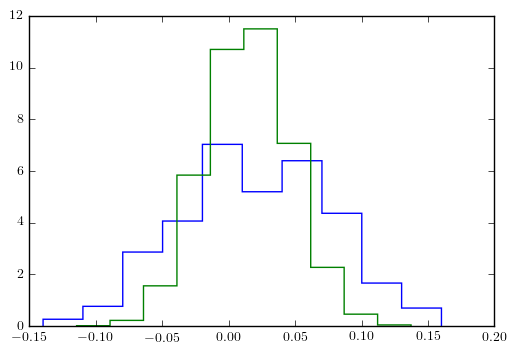

In [75]:
i = 0

print(np.mean(chain[:, i]), np.mean(sampler.flatchain[:, i]))
print(np.std(chain[:, i]), np.std(sampler.flatchain[:, i]))

pl.hist(chain[:, i], histtype="step", normed=True)
pl.hist(sampler.flatchain[:, i], histtype="step", normed=True);